## TRABALHO DE CONCLUSÃO DE CURSO EM CIÊNCIA DE DADOS - PUC MINAS
## Aluno: Anderson Lhoret
## MODELO PREDITIVO DE DURAÇÃO DE OPERAÇÃO DE TRÂNSITO ADUANEIRO
# Notebook 3: Análise Exploratória de Dados

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pycaret.regression import *

import phik
from phik.report import plot_correlation_matrix
from phik import report

## 1. Inicialização dos datasets

In [2]:
# Base tratada
dataset_tratado = 'dataset_tratado.pkl'

# Base pós análise exploratória dos dados
output_file = 'dataset_explorado.pkl'

In [3]:
df = pd.read_pickle(dataset_tratado)

In [4]:
# Imprime as colunas do arquivo
print('Dataset tratado: ' + str(list(df)))

Dataset tratado: ['dt_inicio', 'dt_conclusao', 'peso_bruto', 'origem_latitude', 'origem_longitude', 'dest_realizado_latitude', 'dest_realizado_longitude', 'orig&dest', 'HDD', 'DDS', 'duracao', 'elevacao_origem', 'elevacao_destino', 'delta_elevacao', 'distancia', 'duracao_horas_Google']


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112898 entries, 0 to 113579
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   dt_inicio                 112898 non-null  datetime64[ns]
 1   dt_conclusao              112898 non-null  datetime64[ns]
 2   peso_bruto                112898 non-null  float64       
 3   origem_latitude           112898 non-null  float64       
 4   origem_longitude          112898 non-null  float64       
 5   dest_realizado_latitude   112898 non-null  float64       
 6   dest_realizado_longitude  112898 non-null  float64       
 7   orig&dest                 112898 non-null  object        
 8   HDD                       112898 non-null  category      
 9   DDS                       112898 non-null  object        
 10  duracao                   112898 non-null  float64       
 11  elevacao_origem           112898 non-null  float64       
 12  el

In [6]:
df.head()

,dt_inicio,dt_conclusao,peso_bruto,origem_latitude,origem_longitude,dest_realizado_latitude,dest_realizado_longitude,orig&dest,HDD,DDS,duracao,elevacao_origem,elevacao_destino,delta_elevacao,distancia,duracao_horas_Google
0,2018-11-06 10:30:16,2018-11-09 12:01:08,5064.00,-29.894283,-51.173923,-23.928333,-46.369167,1017800 817800,10,Tuesday,73.514444,14.400117,2.250206,-12.149911,1128.0,13.682500
1,2019-01-15 15:56:09,2019-01-16 16:53:34,14006.72,-22.313276,-49.133789,-25.511146,-54.565616,810300 917500,15,Tuesday,24.956944,596.585388,227.361206,-369.224182,791.0,10.126111
2,2019-01-15 15:06:30,2019-01-16 18:49:45,10005.00,-23.008442,-47.144659,-23.425529,-46.487609,817700 817600,15,Tuesday,27.720833,656.134888,738.550049,82.415161,114.0,1.486667
3,2019-01-15 15:52:30,2019-01-16 16:53:01,15605.88,-22.313276,-49.133789,-25.511146,-54.565616,810300 917500,15,Tuesday,25.008611,596.585388,227.361206,-369.224182,791.0,10.126111
4,2019-01-15 15:01:18,2019-01-17 12:13:32,13588.45,-29.894283,-51.173923,-23.425529,-46.487609,1017800 817600,15,Tuesday,45.203889,14.400117,738.550049,724.149932,1164.0,14.280833


## 2. Análise Preliminar e Filtragem

### 2.1. Análise da relação entre a duração da operação de trânsito aduaneiro e a duração prevista pela API Google.

In [7]:
df['indice_duracao'] = df['duracao'] / df['duracao_horas_Google']

<AxesSubplot:>

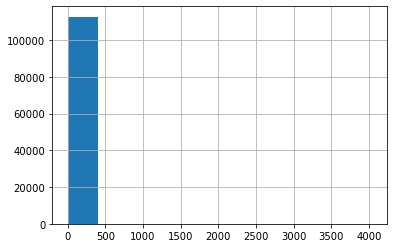

In [8]:
# Histograma do índice duracao/duracao_google 
df['indice_duracao'].hist()

In [9]:
# Contagem de registros com peso_bruto acima do máximo possível para Veículo Pesado com PBTC até 45 toneladas + 5%
print('Total de registros com peso acima limite superior: ' + str(sum(df['peso_bruto'] > 47250)))

print('Total de registros com peso abaixo limite inferior: ' + str(sum(df['peso_bruto'] < 100)))

Total de registros com peso acima limite superior: 5746
Total de registros com peso abaixo limite inferior: 11007


In [10]:
# Contagem de registros com distancia abaixo de 25 Km
print('Total de trajetos <= 25km: ' + str(sum(df['distancia'] <= 25)))

# Contagem de registros com distancia acima de 2.000 Km
print('Total de trajetos >= 2000km: ' + str(sum(df['distancia'] >= 2000)))

Total de trajetos <= 25km: 9329
Total de trajetos >= 2000km: 1484


### 2.2. Filtragem do dataset

Tendo em vista a existência de muitos casos extremos e inclusive incoerentes, procederemos com a filtragem do dataset.

In [11]:
# Exclui linhas com tempo de trajeto superior a N vezes o tempo previsto pelo Google
df_filtrado = df[df['indice_duracao'] < 3]

In [12]:
# Exclui linhas com tempo de trajeto inferior a 90% do tempo previsto pelo Google
df_filtrado = df_filtrado[df_filtrado['indice_duracao'] > 1]

In [13]:
# Exclusao dos registros com peso_bruto acima de 47250 Kg
df_filtrado = df_filtrado[df_filtrado['peso_bruto'] <= 47250]

# Exclusão dos registros com peso_bruto abaixo do limite inferior
df_filtrado = df_filtrado[df_filtrado['peso_bruto'] > 100]

In [14]:
# Exclusão de registros com base na distância
df_filtrado = df_filtrado[df_filtrado['distancia'] > 25]
df_filtrado = df_filtrado[df_filtrado['distancia'] < 2000]

## 3. Análise Exploratória dos Dados

### 3.1. Análise da variável 'duração'

<AxesSubplot:>

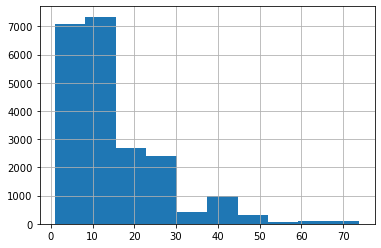

In [15]:
# Histograma do target 'duracao'
df_filtrado['duracao'].hist()

<AxesSubplot:>

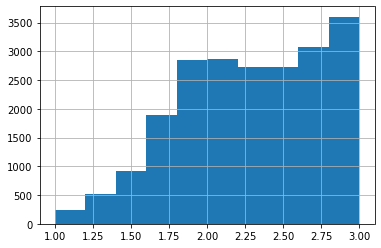

In [16]:
# Histograma do índice duracao/duracao_google 
df_filtrado['indice_duracao'].hist()

In [17]:
df_filtrado['indice_duracao'].describe()

count    21417.000000
mean         2.283161
std          0.463941
min          1.000935
25%          1.928198
50%          2.304227
75%          2.687080
max          3.000000
Name: indice_duracao, dtype: float64

### 3.2. Análise da variável 'distância'

In [18]:
df_filtrado['distancia'].describe()

count    21417.000000
mean       507.501032
std        410.481135
min         26.800000
25%        191.000000
50%        407.000000
75%        679.000000
max       1982.000000
Name: distancia, dtype: float64

<AxesSubplot:>

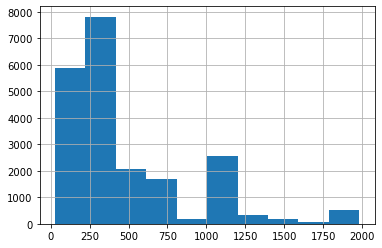

In [19]:
df_filtrado['distancia'].hist()

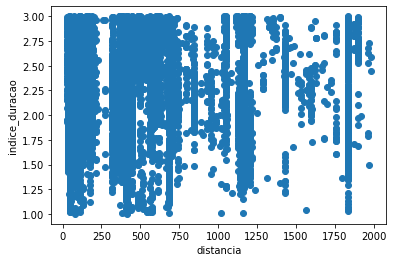

In [20]:
plt.scatter('distancia', 'indice_duracao', data=df_filtrado)
plt.xlabel("distancia")
plt.ylabel("indice_duracao")
plt.show()

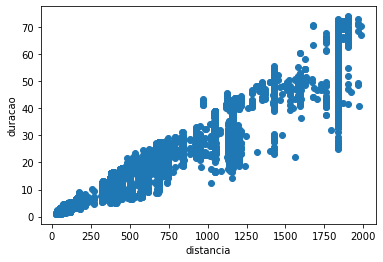

In [21]:
plt.scatter('distancia', 'duracao', data=df_filtrado)
plt.xlabel("distancia")
plt.ylabel("duracao")
plt.show()

### 3.3. Análise da variável 'delta_elevacao'

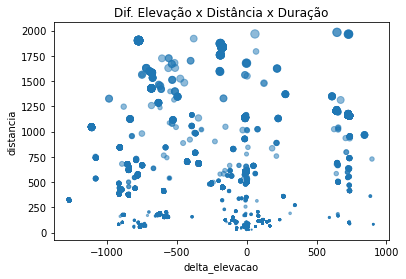

In [22]:
# Avaliação da influência da diferença de altitude na duração das viagens, considerando a distância

plt.xlabel('delta_elevacao')
plt.ylabel('distancia')
plt.title('Dif. Elevação x Distância x Duração')
plt.scatter('delta_elevacao', 'distancia', s='duracao', alpha=0.5, data=df_filtrado)
plt.show()

### 3.4. Análise da variável 'peso'

In [23]:
df_filtrado['peso_bruto'].describe()

count    21417.000000
mean     18055.799395
std      13502.026740
min        100.030000
25%       4692.000000
50%      19825.270000
75%      26400.000000
max      47128.000000
Name: peso_bruto, dtype: float64

<AxesSubplot:>

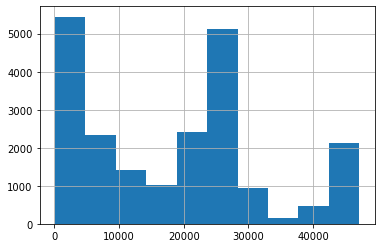

In [24]:
# Histograma da variável 'peso'
df_filtrado['peso_bruto'].hist()

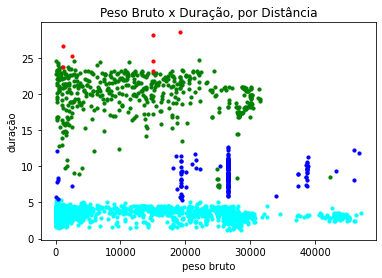

In [25]:
# Avaliação da influência do peso na duração em viagens estratificadas por distância (estratos com amplitude de 50Km)

df_100 = df_filtrado.loc[(df_filtrado['distancia'] > 75) & (df_filtrado['distancia'] < 125), ['duracao', 'peso_bruto']]
df_300 = df_filtrado.loc[(df_filtrado['distancia'] > 275) & (df_filtrado['distancia'] < 325), ['duracao', 'peso_bruto']]
df_600 = df_filtrado.loc[(df_filtrado['distancia'] > 575) & (df_filtrado['distancia'] < 625), ['duracao', 'peso_bruto']]
df_900 = df_filtrado.loc[(df_filtrado['distancia'] > 875) & (df_filtrado['distancia'] < 925), ['duracao', 'peso_bruto']]

plt.xlabel('peso bruto')
plt.ylabel('duração')
plt.title('Peso Bruto x Duração, por Distância')
plt.scatter(df_100['peso_bruto'], df_100['duracao'], s=10, c='cyan')
plt.scatter(df_300['peso_bruto'], df_300['duracao'], s=10, c='blue')
plt.scatter(df_600['peso_bruto'], df_600['duracao'], s=10, c='green')
plt.scatter(df_900['peso_bruto'], df_900['duracao'], s=10, c='red')
plt.show()

In [26]:
df_filtrado.value_counts(subset=['orig&dest'], sort=True).head(3)

orig&dest    
810300 817800    2891
611200 817800    2251
610613 817800    1474
dtype: int64

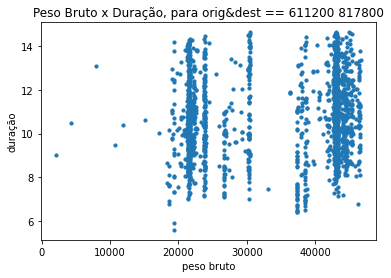

In [27]:
df_aux = df_filtrado.loc[df_filtrado['orig&dest'] == '611200 817800', ['duracao', 'peso_bruto']]

plt.xlabel('peso bruto')
plt.ylabel('duração')
plt.title('Peso Bruto x Duração, para orig&dest == 611200 817800')
plt.scatter(df_aux['peso_bruto'], df_aux['duracao'], s=10)
plt.show()

No ensaio acima o teste de influência do peso bruto na duração foi refeito para um orig&dest específico porém a influência do peso bruto na duração continua não aparecendo explicitamente.

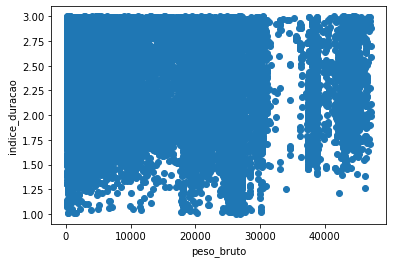

In [28]:
plt.scatter('peso_bruto', 'indice_duracao', data=df_filtrado)
plt.xlabel("peso_bruto")
plt.ylabel("indice_duracao")
plt.show()

In [29]:
# Criação da variável velocidade média
df_filtrado['v_med'] = df_filtrado['distancia'] / df_filtrado['duracao']

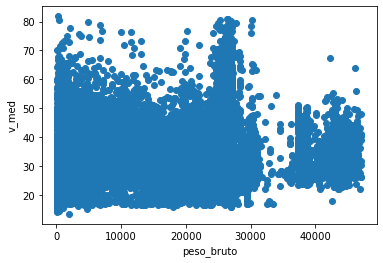

In [30]:
# Gráfico peso x velocidade media
plt.scatter('peso_bruto', 'v_med', data=df_filtrado)
plt.xlabel("peso_bruto")
plt.ylabel("v_med")
plt.show()

### 3.5. Análise da variação de altitude

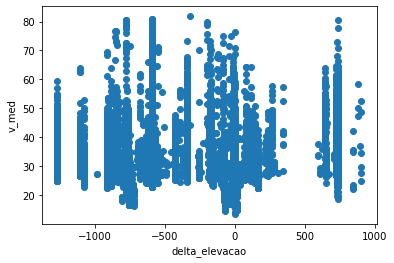

In [31]:
# Gráfico delta elevação x velocidade media
plt.scatter('delta_elevacao', 'v_med', data=df_filtrado)
plt.xlabel("delta_elevacao")
plt.ylabel("v_med")
plt.show()

### 3.6. Análise da variável Hora do Dia (HDD)

<AxesSubplot:>

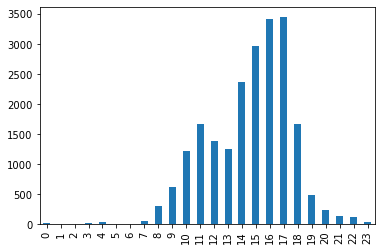

In [32]:
# Gráfico da quantidade de viagens agrupadas por HDD
df_filtrado['HDD'].value_counts().sort_index().plot.bar()

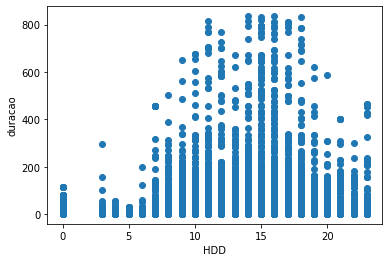

In [33]:
plt.scatter(df['HDD'], df['duracao'])
plt.xlabel("HDD")
plt.ylabel("duracao")
plt.show()

### 3.7. Análise da variável Dia da Semana (DDS)

In [34]:
# Quantidade de viagens agrupadas por DDS
df_filtrado['DDS'].value_counts()

Wednesday    5366
Tuesday      4618
Thursday     3967
Monday       3797
Friday       3445
Saturday      171
Sunday         53
Name: DDS, dtype: int64

<AxesSubplot:>

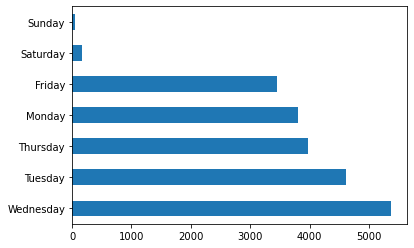

In [35]:
# Gráfico das viagens agrupadas por DDS
df_filtrado['DDS'].value_counts().plot.barh()

### 3.8. Análise da variável orig&dest

In [36]:
#df_filtrado['orig&dest'].value_counts()
n = len(pd.unique(df_filtrado['orig&dest']))
print("Número de pares origem & destino: ", n)

Número de pares origem & destino:  195


### 3.9. Matriz de correlação

In [37]:
# Matriz de correlação
df_corr = df_filtrado[['duracao', 'distancia', 'peso_bruto', 'delta_elevacao']].corr(method='pearson')
df_corr.style.background_gradient(cmap='RdBu')

,duracao,distancia,peso_bruto,delta_elevacao
duracao,1.000000,0.941107,-0.199298,0.357018
distancia,0.941107,1.000000,-0.201102,0.423116
peso_bruto,-0.199298,-0.201102,1.000000,-0.580899
delta_elevacao,0.357018,0.423116,-0.580899,1.000000


### 3.10. Matriz de correlação - Phik

In [38]:
df_corr = df_filtrado[['duracao', 'distancia', 'peso_bruto', 'delta_elevacao', 'HDD', 'DDS']]
interval_cols = ['duracao', 'distancia', 'peso_bruto', 'delta_elevacao', 'HDD']
phik_overview = df_corr.phik_matrix(interval_cols = interval_cols)
phik_overview.round(2)

,duracao,distancia,peso_bruto,delta_elevacao,HDD,DDS
duracao,1.00,0.93,0.67,0.79,0.38,0.20
distancia,0.93,1.00,0.74,0.91,0.41,0.21
peso_bruto,0.67,0.74,1.00,0.79,0.35,0.27
delta_elevacao,0.79,0.91,0.79,1.00,0.45,0.29
HDD,0.38,0.41,0.35,0.45,1.00,0.19
DDS,0.20,0.21,0.27,0.29,0.19,1.00


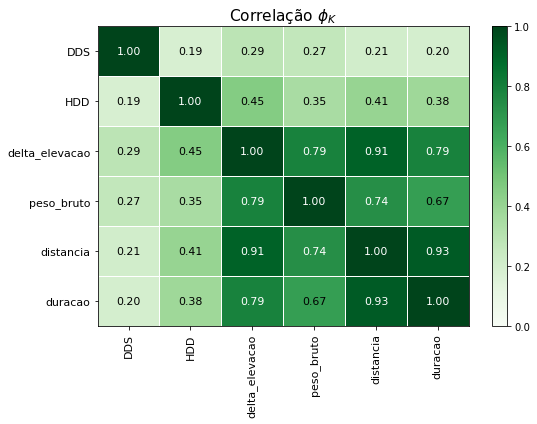

In [39]:
# Matriz de correlação Phik em gráfico de mapa de calor
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title="Correlação $\phi_K$", 
                        fontsize_factor=1.1, 
                        figsize=(8, 6))
plt.tight_layout()

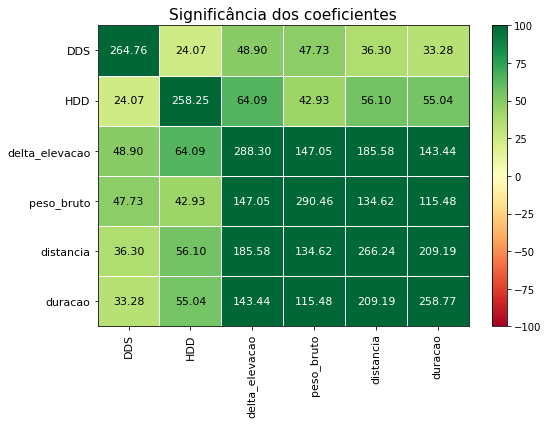

In [40]:
# Matriz de correlação Phik com a significância dos coeficientes
significance_overview = df_corr.significance_matrix(interval_cols = interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-100, vmax=100, title="Significância dos coeficientes", 
                        usetex=False, fontsize_factor=1.1, figsize=(8, 6))
plt.tight_layout()

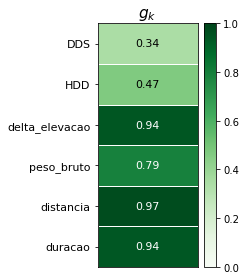

In [41]:
# Correlação global
global_correlation, global_labels = df_corr.global_phik(interval_cols = interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, 
                        figsize=(3.5,4),
                        color_map="Greens", 
                        title="$g_k$",
                        fontsize_factor=1.1)
plt.tight_layout()

## 4. Exportação do Dataset

In [42]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21417 entries, 1 to 113576
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   dt_inicio                 21417 non-null  datetime64[ns]
 1   dt_conclusao              21417 non-null  datetime64[ns]
 2   peso_bruto                21417 non-null  float64       
 3   origem_latitude           21417 non-null  float64       
 4   origem_longitude          21417 non-null  float64       
 5   dest_realizado_latitude   21417 non-null  float64       
 6   dest_realizado_longitude  21417 non-null  float64       
 7   orig&dest                 21417 non-null  object        
 8   HDD                       21417 non-null  category      
 9   DDS                       21417 non-null  object        
 10  duracao                   21417 non-null  float64       
 11  elevacao_origem           21417 non-null  float64       
 12  elevacao_destino 

In [43]:
# Salva dataset após análise exploratória de dados
df_filtrado.to_pickle(output_file)